In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torchvision

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

Usando: cuda


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [5]:
#device = torch.device("cpu")

In [6]:
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
])

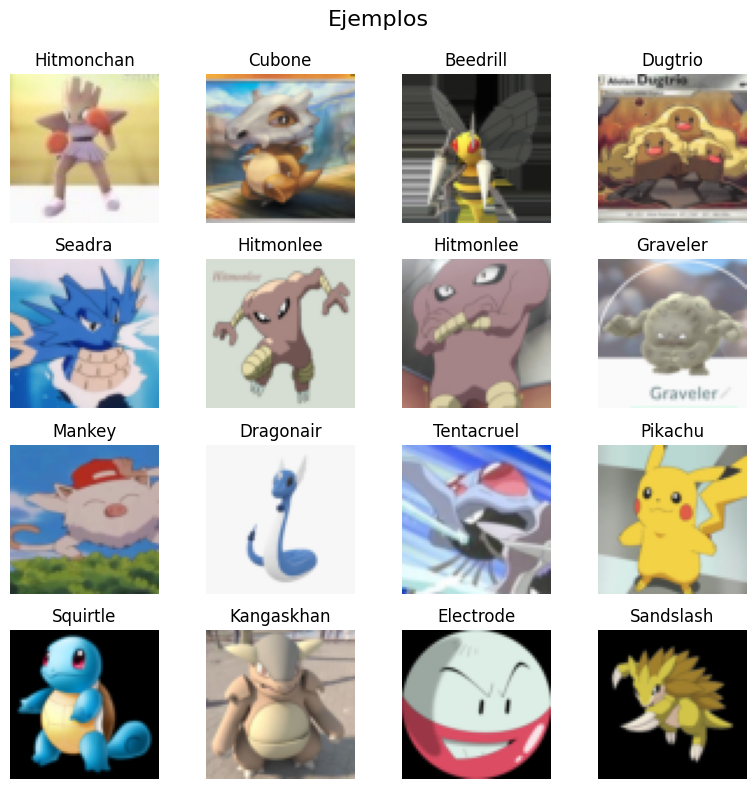

In [7]:
# convierte las imágenes en tensor (Aquí igualamos las resoluciones qls)
raw_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


# Cargar el dataset con solo ToTensor
raw_dataset = torchvision.datasets.ImageFolder(root='C:/Users/Tomás Lara/Desktop/Proyecto Oficial/PokemonData', transform=raw_transform)  #a la hora de probar, actualizar la ruta del dataset
raw_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=16, shuffle=True)

# Obtener un batch de imágenes sin normalizar
images, labels = next(iter(raw_loader))
classes = raw_dataset.classes

# Mostrar las imágenes en una cuadrícula
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("Ejemplos", fontsize=16)

for i in range(16):
    img = images[i].numpy()
    img = np.transpose(img, (1, 2, 0))  # de [C,H,W] a [H,W,C]
    ax = axes[i // 4, i % 4]
    ax.imshow(img)
    ax.set_title(classes[labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
     


Data Augmentation
------------

In [8]:
# Transformaciones con data augmentation (aplicadas directamente al dataset completo)
train_transform = transforms.Compose([
    transforms.Resize(72),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=4),
    transforms.ToTensor()
])

# Transformaciones para testeo (sin augmentación)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [9]:
batch_size = 64

trainset = torchvision.datasets.ImageFolder(root='C:/Users/Tomás Lara/Desktop/Proyecto Oficial/PokemonData', transform=train_transform)
testset = torchvision.datasets.ImageFolder(root='C:/Users/Tomás Lara/Desktop/Proyecto Oficial/PokemonData', transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = trainset.classes

SimpleCNN
--------

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 3, 32, 32] → [B, 32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # → [B, 64, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)               # → [B, 64, 8, 8]
        )        
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(classes))  # salida con tantas clases como pokémon

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64 * 16 * 16)  # flatten, ya que después del segundo MaxPool2d pasas a 8x8
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = SimpleCNN().to(device)

Entrenamiento
-------------

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

def evaluate(loader):
    model.eval()
    total, correct, loss_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = loss_total / total
    accuracy = correct / total
    return avg_loss, accuracy

In [62]:
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # evaluación al final de cada época
    train_loss, train_acc = evaluate(trainloader)
    val_loss, val_acc = evaluate(testloader)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Época {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")


Época 1/40 - Loss: 3.0718 - Acc: 0.2314 - Val Loss: 2.9600 - Val Acc: 0.2600
Época 2/40 - Loss: 2.7799 - Acc: 0.2852 - Val Loss: 2.6246 - Val Acc: 0.3180
Época 3/40 - Loss: 2.7041 - Acc: 0.2985 - Val Loss: 2.5593 - Val Acc: 0.3306
Época 4/40 - Loss: 2.5047 - Acc: 0.3485 - Val Loss: 2.3168 - Val Acc: 0.3884
Época 5/40 - Loss: 2.4563 - Acc: 0.3522 - Val Loss: 2.2702 - Val Acc: 0.4088
Época 6/40 - Loss: 2.5210 - Acc: 0.3364 - Val Loss: 2.3502 - Val Acc: 0.3708
Época 7/40 - Loss: 2.4956 - Acc: 0.3443 - Val Loss: 2.3378 - Val Acc: 0.3826
Época 8/40 - Loss: 2.2722 - Acc: 0.3984 - Val Loss: 2.0714 - Val Acc: 0.4446
Época 9/40 - Loss: 2.2062 - Acc: 0.4059 - Val Loss: 2.0148 - Val Acc: 0.4444
Época 10/40 - Loss: 2.2556 - Acc: 0.4031 - Val Loss: 2.0500 - Val Acc: 0.4471
Época 11/40 - Loss: 2.1453 - Acc: 0.4214 - Val Loss: 1.9357 - Val Acc: 0.4779
Época 12/40 - Loss: 2.1987 - Acc: 0.4075 - Val Loss: 2.0224 - Val Acc: 0.4494
Época 13/40 - Loss: 2.0872 - Acc: 0.4449 - Val Loss: 1.9028 - Val Acc: 0.

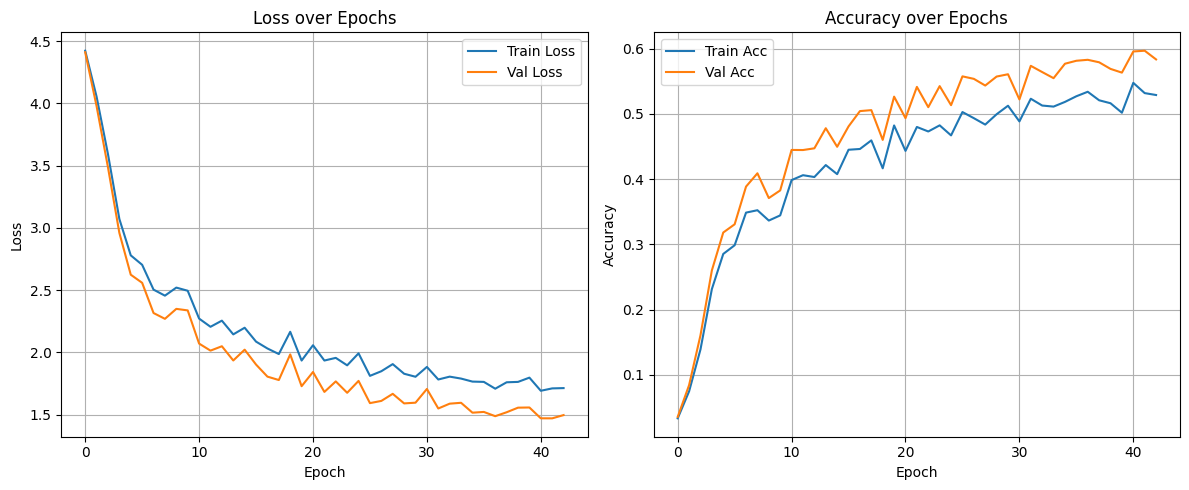

In [63]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Parte para el testeo
-----------------------

Aquí cargas el pokemon que quieres identificar, recuerda que debe ser 1 de los 150 originales.

In [80]:
# Ruta personalizada (usuario la cambia)
ruta_pokemon = "prueba6.jpeg"  # ← Aquí el usuario pone su imagen

# Función para cargar imagen desde ruta
def load_user_image(path):
    image = Image.open(path).convert('RGB')
    image = test_transform(image)  # usamos el mismo transform del modelo
    image = image.unsqueeze(0)  # batch de tamaño 1
    return image.to(device)

In [82]:
# Cargar imagen desde ruta
image_tensor = load_user_image(ruta_pokemon)

# Hacer predicción
model.eval()
with torch.no_grad():
    outputs = model(image_tensor)
    _, pred = torch.max(outputs, 1)
    predicted_class = classes[pred.item()]

print(f"El modelo predice que es: {predicted_class}")


El modelo predice que es: Mewtwo
